# Plots of efficiency and power generated by physical variables

In [1]:
import pandas as pd
from matplotlib import pyplot as plt, dates
import numpy as np
import os

In [2]:
Solcast_Path = '../Private_Data/Solcast/Solcast_Formatted.csv'
Public = False

# Checking if the necessary files exist for formatting.
if not os.path.exists(Solcast_Path):
    print(f"Warning: Some of this script will not run without the formatted Solcast data in {Solcast_Path}`.\n",
          'Please download the data from `solcast.com` at 5 minute cadence for all of 2023.\n',
          'Then run the script in `Scripts/Utils/Format_Solcast.ipynb` to format the data.')
    Public = True

In [3]:
DEOP = pd.read_csv('../Data/DEOP/2023_DEOP_Interp.csv',
                    parse_dates=['DateTime'],
                    index_col=['DateTime']).astype(float)

Const = pd.read_csv('../Data/Analysis/Const/Const.csv',
                    index_col=['Parameter'])

if Public is False:
    Solcast = pd.read_csv(Solcast_Path,
                        parse_dates=['DateTime'],
                        index_col=['DateTime']).astype(float)
    stats = pd.DataFrame()
else:
    Solcast = None

## Calculating power expectation
For wind power, the equation 
$$P_{\mathrm{wind}} = \frac{1}{2} \rho A u_0^3,$$
is used, where $P_{\mathrm{wind}}$ is the power of the wind, $A$ is the area swept by the turbine blades, $u_0$ is wind speed.

$\rho$ is calculated using the equation
$$\rho = \frac{p}{R_{\mathrm{specific}}T}$$
where $p$ is surface pressure, $R_{\mathrm{specific}}$ is the specific gas constant of dry air and $T$ is temperature.

In [17]:
if Public is False:

    Solcast['P_KEWind'] = (Const.loc['A_wtE44']+Const.loc['A_wtE53']).values[0]*(Solcast['wind_speed_100m']**3)*(0.5/1e3)*((Solcast['surface_pressure']*1e2).divide(Solcast['air_temp']+273.15))/Const.loc['R_spec'].values[0]
    Solcast['P_MaxSolar'] = Solcast['gti']*(Const.loc['A_pvUnit']*Const.loc['N_pv']).values[0]/1e3

    Solcast.to_csv('../Private_Data/Solcast/Power_Expectation.csv',index=True,columns=['P_KEWind','P_MaxSolar'])

In [19]:
def PlotEfficiencyPower(Public,DEOP,Solcast,DEOP_cols,Solcast_cols,
                        Efficiency_cols,x_col,bin_size,
                        y_labels,x_label,data_labels,fig_name,
                        y2_col=None,y_lims=None,x_lim=None,
                        Filter_Range=None,Filter_Cols=None,Bin=True,
                        loc=None,save_fig=False,title=None):
    """
    Function plotting efficiencies and power

    Parameters
    ----------
    Public : boolean
        If True, it will be run using the public verison
        If False, it will be run using the private verison
    DEOP : DataFrames
        DEOP data
    Solcast : DataFrame
        Solcast data
    DEOP_cols : List
        List of DEOP data columns of interest (str)
    Solcast_cols : List
        List of Solcast data columns of interest (str)
    Efficiency_cols : List
        List of column names to be considered when calculating efficiency (str)
        First is divided by second to calculate efficiency
    x_col : str
        Column to be used for binning (along the x-axis)
    bin_size : float
        size of bin (as fraction of the range of data in x_col)
    y_labels : List
        list of labels for y-axes (str)
    x_label : str
        label for x-axis
    y_lims : List
        list of limits for y-axes (float)
    x_lim : float
        limits for x-axis
    data_labels : strings
        labels to describe data in legend
    fig_name : str
        Name under which the figure will be saved.
    y2_col : str
        Column to be used for second y-axis (first if using no Solcast data)
        Defaults to None
    Filter_Range : List
        List of constraints to filter by (float)
    Filter_Cols : List
        List of columns corresponding to filters (str)
        Defaults to None
    Bin : boolean
        If True, data are binned
        If Fase, data are not binned (a scatter plot is made)
        Defaults to True
    loc : float or string
        location of legend
        Defaults to None
    save_fig : boolean
        If True, the figure is saved. 
        If False, the figure is not saved.
        Defaults to False
    title : str
        Title given to plot (only on png outputs).
    """
    merged = pd.DataFrame()

    for DEOP_col in DEOP_cols:
        merged = pd.concat([merged,DEOP[DEOP_col]], axis=1)
    
    if Public is False:
        for Solcast_col in Solcast_cols:
            merged = pd.concat([merged,Solcast[Solcast_col]], axis=1)

    if Filter_Range is not None:
        for i in range(len(Filter_Cols)):
            merged = merged[(merged[Filter_Cols[i]] > Filter_Range[i][0]) & (merged[Filter_Cols[i]] <= Filter_Range[i][1])]
    
    if Public is False:
        ### Calculate Efficiency ###
        merged['Efficiency'] = merged[Efficiency_cols[0]].divide(merged[Efficiency_cols[1]])
    
    ## Setting up figure ##

    fig, ax1 = plt.subplots()

    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_labels[0])

    if x_lim is not None:
        ax1.set_xlim(x_lim)
    if y_lims is not None:
        ax1.set_ylim(y_lims[0])

    ## Binning ##
    if Bin is True:

        Rng = merged[x_col[0]].max() - merged[x_col[0]].min()
        BinSize = Rng * bin_size

        bins = np.arange(merged[x_col[0]].min(),merged[x_col[0]].max() + BinSize, BinSize)
        labels = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]
        merged['Bin'] = pd.cut(merged[x_col[0]], bins=bins, labels=labels)
        
        if Public is False:
            Binned_1 = merged.groupby('Bin',observed=False).agg(eta=('Efficiency', 'mean')).reset_index()
            Binned_2 = merged.groupby('Bin',observed=False).agg(power=(y2_col, 'mean')).reset_index()
            if y2_col is not None:
                Binned_2 = merged.groupby('Bin',observed=False).agg(power=(y2_col, 'mean')).reset_index()
        else: 
            Binned_1 = merged.groupby('Bin',observed=False).agg(eta=(y2_col, 'mean')).reset_index()

        for i in range(len(Binned_1)):
            bin_index = Binned_1['Bin'].cat.codes[i]
            bin_start = bins[bin_index]
            bin_end = bins[bin_index + 1]
            if i == range(len(Binned_1))[-1]:
                ax1.hlines(Binned_1['eta'][i], bin_start, bin_end, colors='k',label=data_labels[0])
            else:
                ax1.hlines(Binned_1['eta'][i], bin_start, bin_end, colors='k')

        if Public is False and y2_col is not None:
            ax2 = ax1.twinx()
            ax2.set_ylabel(y_labels[1])
            for i in range(len(Binned_2)):
                bin_index = Binned_2['Bin'].cat.codes[i]
                bin_start = bins[bin_index]
                bin_end = bins[bin_index + 1]
                if i == range(len(Binned_2))[-1]:
                    ax2.hlines(Binned_2['power'][i], bin_start, bin_end, colors='orange',label=data_labels[1])
                else:
                    ax2.hlines(Binned_2['power'][i], bin_start, bin_end, colors='orange')

            if y_lims is not None:
                ax2.set_ylim(y_lims[1])
            else:
                ax2.set_ylim(bottom=0)
    
    else:
        if Public is True:
            ax1.scatter(merged[x_col[0]],merged[y2_col],marker='.',s=0.4,c='k',label=data_labels[0])

        else:
            ax1.scatter(merged[x_col[0]],merged['Efficiency'],marker='.',s=0.4,c='k',label=data_labels[0])
            if y2_col is not None:
                ax2 = ax1.twinx()
                ax2.scatter(merged[x_col[0]],merged[y2_col],marker='.',s=0.4,c='orange',label=data_labels[1])
                ax2.set_ylabel(y_labels[1])

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    ax1.tick_params(axis='both', direction='in')
    ax2.tick_params(axis='y', direction='in')

    ax1.legend(lines + lines2, labels + labels2,loc=loc)

    fig.tight_layout()
    
    if save_fig is True:
        fig.savefig(f'../Figures/pdf/{fig_name}.pdf')
        ax1.set_title(title)
        fig.tight_layout()
        fig.savefig(f'../Figures/png/{fig_name}.png')

    if Public is False:
        return (merged['Efficiency'].mean(),np.sqrt(merged['Efficiency'].var()))
    else:
        return (None,None)

### Plotting Efficiency Graphs

Efficiency =  0.175 +/- 0.16


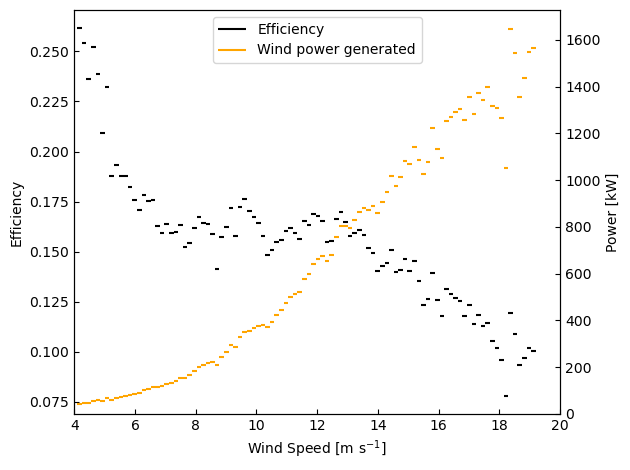

In [20]:
WindEta, dWindEta = PlotEfficiencyPower(Public,DEOP,Solcast,['power-gen-wt-ave'],['P_KEWind','wind_speed_100m'],
                    ['power-gen-wt-ave','P_KEWind'],['wind_speed_100m'],0.01,['Efficiency','Power [kW]'],
                    r'Wind Speed $\left[\mathrm{m\ s^{-1}}\right]$',['Efficiency','Wind power generated'],
                    'Renewable_Energy_Efficiency_Wind','power-gen-wt-ave',
                    Filter_Range=[[0,1.9e3],[4,40.]],Filter_Cols=['power-gen-wt-ave','wind_speed_100m'],loc=9,x_lim=(4,20),
                    title='Efficiency of wind power production during 2023 over varying wind speeds')
if Public is False:
    print('Efficiency = ',"{0:.3g}".format(WindEta),'+/-',"{0:.2g}".format(dWindEta))
    stats.loc['eta_Wind','mean'] = WindEta
    stats.loc['eta_Wind','sigma'] = dWindEta

Efficiency =  0.184 +/- 0.16


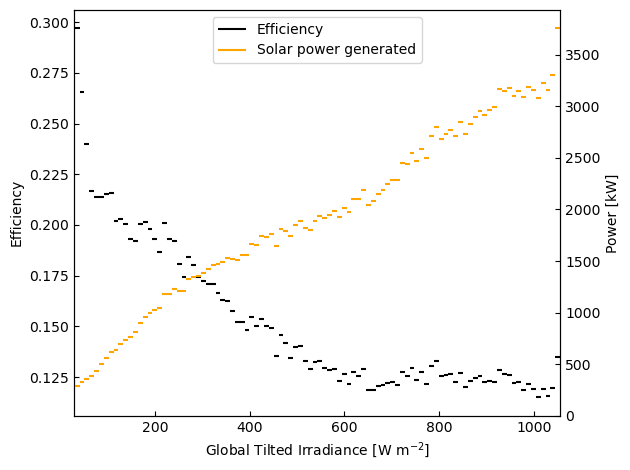

In [21]:
SolarEta, dSolarEta = PlotEfficiencyPower(Public,DEOP,Solcast,['power-gen-pv-ave'],['P_MaxSolar','gti'],
                    ['power-gen-pv-ave','P_MaxSolar'],['gti'],0.01,['Efficiency','Power [kW]'],
                    r'Global Tilted Irradiance $\left[\mathrm{W\ m^{-2}}\right]$',['Efficiency','Solar power generated'],
                    'Renewable_Energy_Efficiency_Solar','power-gen-pv-ave',
                    Filter_Range=[[0,5e3],[30,1055]],Filter_Cols=['power-gen-pv-ave','gti'],loc=9,x_lim=(30,1055),
                    title='Efficiency of solar power production during 2023 over varying irradiances')
if Public is False:
    print('Efficiency = ',"{0:.3g}".format(SolarEta),'+/-',"{0:.2g}".format(dSolarEta))
    stats.loc['eta_Solar','mean'] = SolarEta
    stats.loc['eta_Solar','sigma'] = dSolarEta

### Plotting Histograms

In [22]:
def SolcastHistogram(Public,Solcast_col,x_label,fig_name,title,bin_size,x_lim=None,save_fig=False,log=False):
    """
    Function plotting a histogram of Solcast data

    Parameters
    ----------
    Public : boolean
        If True, it will be run using the public verison
        If False, it will be run using the private verison
    Solcast_col : DataFrame
        Solcast data to plot (one column)
    x_label : str
        label for x-axis
    fig_name : str
        Name under which the figure will be saved.
    title : str
        Title given to plot (only on png outputs).
    bin_size : float
        Size of bin (as fraction of the range of data in x_col).
    x_lim : float
        Limits for x-axis.
        Defaults to None.
    save_fig : boolean
        If True, the figure is saved. 
        If False, the figure is not saved.
        Defaults to False.
    log : boolean
        If True, a logarithmic scale is used for the y-axis.
        If False, a linear scale is used for the y-axis.
        Defaults to False.
    """
    if Public is True:
        print('Warming: This script cannot run because there is no Solcast data available.')
        return
    else:
        fig, ax1 = plt.subplots()
        ax1.set_xlabel(x_label)
        ax1.set_ylabel('Normalised Frequency')

        # Setting bins

        Rng = Solcast_col.max() - Solcast_col.min()
        BinSize = Rng * bin_size

        bins = np.arange(Solcast_col.min(),Solcast_col.max() + BinSize, BinSize)

        ax1.hist(Solcast_col,bins=bins,density=True)

        if log is True:
            ax1.set_yscale('log')
        
        if x_lim is not None:
            ax1.set_xlim(x_lim)
        else:
            ax1.set_xlim(left=0)
        
        ax1.tick_params(axis='both', direction='in',labelleft=True,labelright=True,left=True,right=True)

        fig.tight_layout()

        if save_fig is True:
            fig.savefig(f'../Figures/pdf/{fig_name}.pdf')
            ax1.set_title(title)
            fig.tight_layout()
            fig.savefig(f'../Figures/png/{fig_name}.png')
    sigma = np.sqrt(Solcast_col.var())
    mean = Solcast_col.mean()
    return sigma,mean

Standard Deviation =  2.99
Mean =  6.9


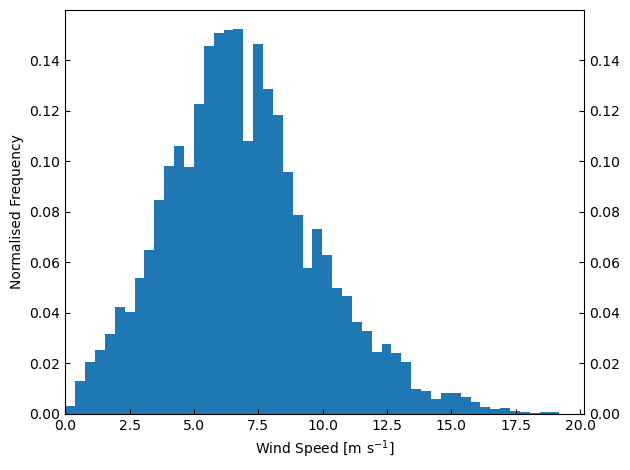

In [23]:
sigma,mean = SolcastHistogram(Public,Solcast['wind_speed_100m'],r'Wind Speed $\left[\mathrm{m\ s^{-1}}\right]$',
                 'Histogram_Wind_Speed','Histogram of Wind Speeds in 2023',0.02)
if Public is False:
    print('Standard Deviation = ',"{0:.3g}".format(sigma))
    print('Mean = ',"{0:.3g}".format(mean))
    stats.loc['Wind Speed [m/s]','mean'] = mean
    stats.loc['Wind Speed [m/s]','sigma'] = sigma
    

Standard Deviation =  234
Mean =  136  W/m^2


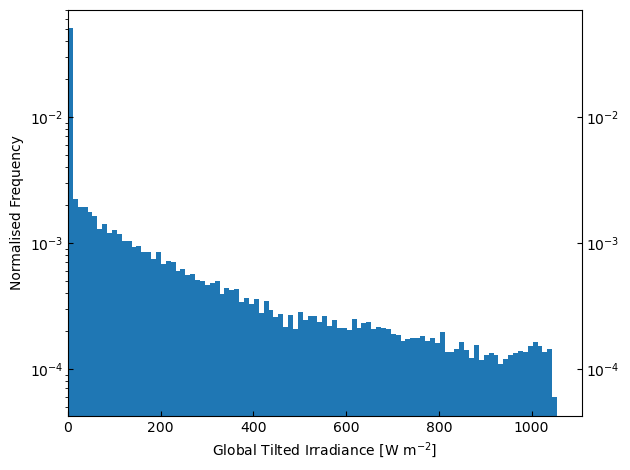

In [24]:
sigma,mean = SolcastHistogram(Public,Solcast['gti'],r'Global Tilted Irradiance $\left[\mathrm{W\ m^{-2}}\right]$',
                 'Histogram_GTI','Histogram of Global Tilted Irradiance in 2023',0.01,log=True)

if Public is False:
    print('Standard Deviation = ',"{0:.3g}".format(sigma))
    print('Mean = ',"{0:.3g}".format(mean),' W/m^2')
    stats.loc['Global Tilted Irradiance [W/m2]','mean'] = mean
    stats.loc['Global Tilted Irradiance [W/m2]','sigma'] = sigma

In [25]:
stats.to_csv('../Data/Analysis/Data_Tables/csv/statistics.csv')

### Plotting time spent within values which allow for energy generation

In [26]:
def PlotMonthly(Public,DEOP,Solcast,
                DEOP_col, Solcast_col,
                data_labels,fig_name,title,
                Filter_Range,
                y_lim=None,
                loc=None,save_fig=False):
    """
    Function plotting activity and expected activity over time.

    Parameters
    ----------
    Public : boolean
        If True, it will be run using the public verison.
        If False, it will be run using the private verison.
    DEOP : pd.DataFrame
        DEOP data
    Solcast : pd.DataFrame
        Solcast data
    DEOP_col : List
        DEOP data columns of interest
    Solcast_col : List
        Solcast data column of interest
    data_labels : List
        labels to describe data in legend (str)
    fig_name : str
        Name under which the figure will be saved.
    title : str
        Title given to plot (only on png outputs).
    Filter_Range : tuple
        Range which energy can be generated (of values in Solcast_col)
    y_lim : floats
        list of limits for left y axis
    loc : float or str
        location of legend
    save_fig : boolean
        If True, the figure is saved. 
        If False, the figure is not saved.
        Defaults to False
    """
    fig, ax1 = plt.subplots()

    if Public is False:
        Solcast['activity'] = 1
        Filtered_Solcast = Solcast[(Solcast[Solcast_col] > Filter_Range[0]) & (Solcast[Solcast_col] <= Filter_Range[1])]
        
        Solcast_Monthly = Solcast.resample('ME').sum().to_period('M').to_timestamp()
        Filtered_Solcast_Monthly = Filtered_Solcast.resample('ME').sum().to_period('M').to_timestamp()

        Solcast_Monthly_Activity = Filtered_Solcast_Monthly['activity'].divide(Solcast_Monthly['activity'])

    DEOP['activity'] = 1
    Filtered_DEOP = DEOP[(DEOP[DEOP_col] > 0)]
    
    DEOP_Monthly = DEOP.resample('ME').sum().to_period('M').to_timestamp()
    Filtered_DEOP_Monthly = Filtered_DEOP.resample('ME').sum().to_period('M').to_timestamp()

    DEOP_Monthly_Activity = Filtered_DEOP_Monthly['activity'].divide(DEOP_Monthly['activity'])

    if Public is False:
        ax1.plot(Solcast_Monthly_Activity.index,Solcast_Monthly_Activity,label=data_labels[1],c='#009E73')

    ax1.plot(DEOP_Monthly_Activity.index,DEOP_Monthly_Activity,label=data_labels[0],c='k',ls='dotted')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Monthly Fractional Activity')

    ax1.xaxis.set_major_formatter(dates.DateFormatter('%b')) # formatting the date
    ax1.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-01'))

    ax1.tick_params(axis='both', direction='in',labelleft=True,labelright=True,left=True,right=True)

    if y_lim is not None:
        ax1.set_ylim(y_lim)
    else:
        ax1.set_ylim(0,1)

    ax1.legend(loc=loc)
    
    fig.autofmt_xdate()
    fig.tight_layout()
    if save_fig is True:
        fig.savefig(f'../Figures/pdf/{fig_name}.pdf')
        ax1.set_title(title)
        fig.tight_layout()
        fig.savefig(f'../Figures/png/{fig_name}.png')

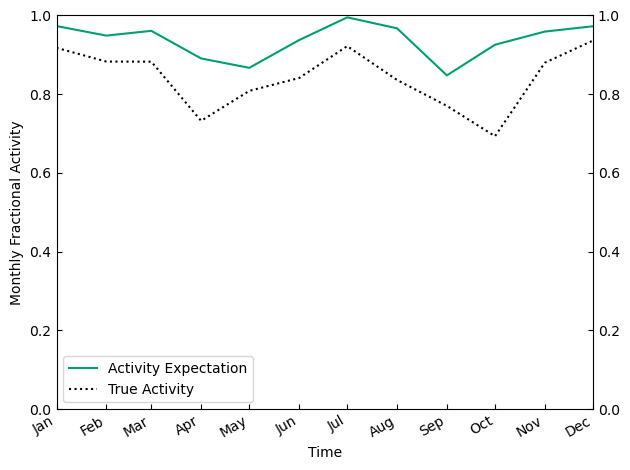

In [27]:
PlotMonthly(Public,DEOP,Solcast,'power-gen-wt-ave','wind_speed_100m',['True Activity','Activity Expectation'],
            'Wind_Turbine_Activity','Monthly activity of wind turbines over 2023',(2.5,34))

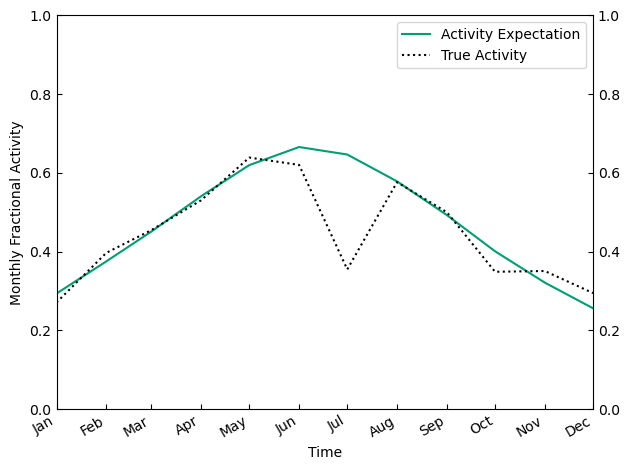

In [28]:
PlotMonthly(Public,DEOP,Solcast,'power-gen-pv-ave','gti',['True Activity','Activity Expectation'],
            'Solar_Panel_Activity','Monthly activity of solar panels over 2023',(0.01*1055,1055))